In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

input_vars = ['p1', 'p2', 'p3', 'p4', 'p5']
output_var = 'prod'

df = pd.read_csv('../data/tryptophan_production.csv', index_col=0)
df.rename({'dgfp_dt':'prod'}, axis=1, inplace=True)
print(df.shape)

(792, 7)


In [101]:
# Get only Name from Line Name
df['Name'] = df['Line Name'].apply(lambda x: x.split('-')[0])
df['Name'].nunique()
df.head()

,Line Name,prod,p1,p2,p3,p4,p5,Name
0,SP003-r1,99.225224,2.0,11.0,13.0,24.0,29.0,SP003
1,SP003-r2,107.346770,2.0,11.0,13.0,24.0,29.0,SP003
2,SP003-r3,109.504167,2.0,11.0,13.0,24.0,29.0,SP003
3,SP004-r1,169.829824,2.0,11.0,13.0,19.0,25.0,SP004
4,SP004-r2,155.425955,2.0,11.0,13.0,19.0,25.0,SP004


In [102]:
# Group by Line Name
replicate_mean = df.groupby('Name')['prod'].mean()

# Concat with original df
df = df.merge(replicate_mean, on='Name', suffixes=('', '_mean'))
df.rename({'prod_mean':'Replicate_Mean'}, axis=1, inplace=True)
df['Replicate_Error'] = df['prod'] - df['Replicate_Mean']

In [103]:
# Find rows with Replica_Error higher than 99% of all rows
df[df['Replicate_Error'].abs() >= df['Replicate_Error'].abs().quantile(0.99)]

,Line Name,prod,p1,p2,p3,p4,p5,Name,Replicate_Mean,Replicate_Error
337,SP224-r1,79.990664,6.0,12.0,13.0,20.0,28.0,SP224,123.932894,-43.942229
339,SP224-r3,174.085502,6.0,12.0,13.0,20.0,28.0,SP224,123.932894,50.152609
525,SP350-r1,278.266173,1.0,9.0,13.0,21.0,29.0,SP350,161.715406,116.550767
527,SP350-r3,51.049123,1.0,9.0,13.0,21.0,29.0,SP350,161.715406,-110.666283
528,SP354-r1,69.047804,4.0,8.0,13.0,20.0,27.0,SP354,120.296245,-51.248441
530,SP354-r3,171.159184,4.0,8.0,13.0,20.0,27.0,SP354,120.296245,50.862939
553,SP365-r2,227.141780,4.0,12.0,15.0,20.0,26.0,SP365,180.436352,46.705428
582,SP380-r1,193.137657,1.0,11.0,13.0,19.0,27.0,SP380,144.095323,49.042334


In [104]:
# Drop rows with Replicate_Error higher than 99% 
df = df[df['Replicate_Error'].abs() < df['Replicate_Error'].abs().quantile(0.99)]
df.shape

(784, 10)

In [105]:
lines_to_drop = ['SP224-r1', 'SP224-r2', 'SP224-r3', 'SP350-r1', 'SP350-r2', 'SP350-r3', 'SP354-r1', 'SP354-r2', 'SP354-r3', 'SP365-r1', 'SP365-r2', 'SP365-r3', 'SP380-r1', 'SP380-r2', 'SP380-r3']
len(lines_to_drop)

df = df[~df['Name'].isin(lines_to_drop)]

In [106]:
df.drop(['Replicate_Error', 'Replicate_Mean'], axis=1, inplace=True)
data = df.groupby('Name').mean(numeric_only=True)
data[input_vars] = data[input_vars].astype(str)

In [111]:
# Label encode input variables
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data[input_vars] = data[input_vars].apply(le.fit_transform)
data.head(3)

,prod,p1,p2,p3,p4,p5
Name,,,,,,
SP003,105.358720,1,1,0,5,4
SP004,159.715748,1,1,0,0,0
SP008,112.879576,1,1,2,3,0


In [119]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

X = data[input_vars]
y = data[output_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

xgb = XGBRegressor()

param_grid = {
    'n_estimators': np.arange(3, 500, 25),
    'max_depth': np.arange(1, 10),
    'learning_rate': np.arange(0.01, 0.1, 0.01),
    'subsample': np.arange(0.1, 1, 0.1),
    'colsample_bytree': np.arange(0.1, 1, 0.1),
    'gamma': np.arange(0, 5),
    'reg_alpha': np.arange(0, 5),
    'reg_lambda': np.arange(0, 5)
}

grid = RandomizedSearchCV(xgb, param_grid, n_iter=200, cv=5, verbose=1, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

model = grid.best_estimator_

y_pred = model.predict(X_test)
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(f'RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RMSE = 24.477917813263417
MAE = 18.33203523553177


In [122]:
X_train = data.copy()

scaler = MinMaxScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_train.head()

,prod,p1,p2,p3,p4,p5
Name,,,,,,
SP003,0.290819,0.2,0.2,0.0,1.0,0.8
SP004,0.547310,0.2,0.2,0.0,0.0,0.0
SP008,0.326307,0.2,0.2,0.4,0.6,0.0
SP011,0.553361,0.0,1.0,0.0,0.6,0.0
SP014,0.731755,0.8,1.0,0.0,0.6,0.0


In [145]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam

def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = 32
latent_dim = 2

# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='silu')(inputs)
x = Dense(intermediate_dim, activation='silu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='silu')(latent_inputs)
x = Dense(intermediate_dim, activation='silu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')

# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

opt = Adam(learning_rate=0.0001)
vae_model.compile(optimizer=opt, loss=vae_loss)
results = vae_model.fit(X_train, X_train, validation_split=0.2, shuffle=True, epochs=1000, batch_size=32, verbose=1)

Train on 212 samples, validate on 54 samples
Epoch 1/1000


2024-05-29 14:47:57.412191: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_73/kernel/Assign' id:10175 op device:{requested: '', assigned: ''} def:{{{node dense_73/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_73/kernel, dense_73/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 32/212 [===>..........................] - ETA: 3s - loss: 20.3744

/home/WUR/g0012069/env/main/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-05-29 14:47:57.836590: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_13/mul' id:10292 op device:{requested: '', assigned: ''} def:{{{node loss_13/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_13/mul/x, loss_13/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


212/212 [==============================] - 1s 4ms/sample - loss: 20.6845 - val_loss: 18.7574
Epoch 2/1000
212/212 [==============================] - 0s 227us/sample - loss: 20.4608 - val_loss: 18.7836
Epoch 3/1000
212/212 [==============================] - 0s 201us/sample - loss: 20.7413 - val_loss: 18.6229
Epoch 4/1000
212/212 [==============================] - 0s 226us/sample - loss: 20.4530 - val_loss: 18.3363
Epoch 5/1000
212/212 [==============================] - 0s 176us/sample - loss: 20.6496 - val_loss: 18.8770
Epoch 6/1000
212/212 [==============================] - 0s 181us/sample - loss: 20.4953 - val_loss: 18.4825
Epoch 7/1000
212/212 [==============================] - 0s 191us/sample - loss: 20.4632 - val_loss: 18.5205
Epoch 8/1000
212/212 [==============================] - 0s 182us/sample - loss: 20.6196 - val_loss: 18.5310
Epoch 9/1000
212/212 [==============================] - 0s 170us/sample - loss: 20.6347 - val_loss: 18.4389
Epoch 10/1000
212/212 [====================

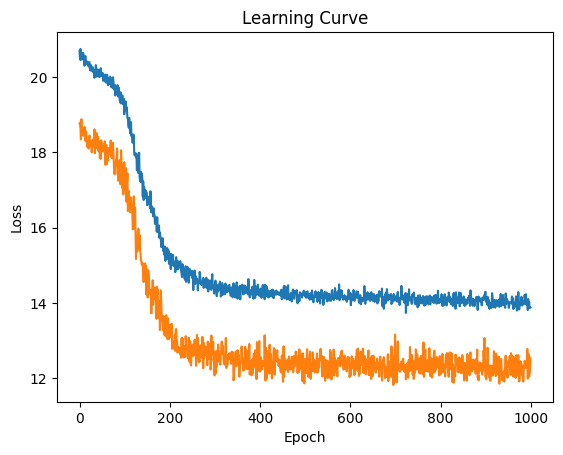

In [146]:
# Plot learning rate
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Learning Curve')
plt.ylabel('Loss')
# plt.yscale('log')
plt.xlabel('Epoch')
plt.show()

In [147]:
# Get the latent representation of the input data
X_train_encoded = encoder.predict(X_train)

/home/WUR/g0012069/env/main/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-05-29 14:48:47.695843: W tensorflow/c/c_api.cc:305] Operation '{name:'z_13/add' id:10103 op device:{requested: '', assigned: ''} def:{{{node z_13/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](z_mean_13/BiasAdd, z_13/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [148]:
X_train_encoded = pd.DataFrame(X_train_encoded, index=X_train.index, columns=[f"z_{i}" for i in range(latent_dim)])
X_train_encoded['prod'] = y_train

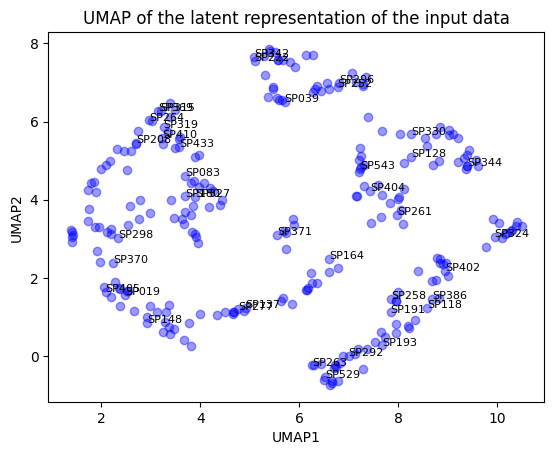

In [149]:
# Perform UMAP in latent space
import umap

umap_model = umap.UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train_encoded.drop(columns='prod'))
X_train_umap = pd.DataFrame(X_train_umap, index=X_train.index, columns=['UMAP1', 'UMAP2'])
X_train_umap['prod'] = y_train
# Plot 2D plot of the latent representation
plt.scatter(X_train_umap['UMAP1'], X_train_umap['UMAP2'], color='blue', alpha=0.4)
# Print lables if prod is greater than 0.2
for i, txt in enumerate(X_train_umap.index):
    if X_train_umap['prod'][i] > 200:
        plt.text(X_train_umap['UMAP1'][i], X_train_umap['UMAP2'][i], txt, fontsize=8)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP of the latent representation of the input data')
plt.show()


In [150]:
pd.DataFrame(vae_model.predict(X_train), columns=X_train.columns, index=X_train.index)

/home/WUR/g0012069/env/main/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-05-29 14:49:22.530037: W tensorflow/c/c_api.cc:305] Operation '{name:'decoder_13/dense_73/Sigmoid' id:10256 op device:{requested: '', assigned: ''} def:{{{node decoder_13/dense_73/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder_13/dense_73/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


,prod,p1,p2,p3,p4,p5
Name,,,,,,
SP003,0.537645,0.681802,0.334294,0.466077,0.763486,0.713813
SP004,0.502854,0.093041,0.679423,0.287488,0.067269,0.362843
SP008,0.543700,0.389446,0.595665,0.400969,0.511905,0.250951
SP011,0.593785,0.210399,0.860589,0.545921,0.434885,0.033654
SP014,0.545337,0.486382,0.597375,0.426564,0.684665,0.188179
...,...,...,...,...,...,...
SP553,0.579388,0.186413,0.775644,0.428187,0.281840,0.094998
SP554,0.567131,0.262017,0.735568,0.427132,0.410367,0.107238
SP556,0.557483,0.197296,0.712714,0.384466,0.247508,0.170479


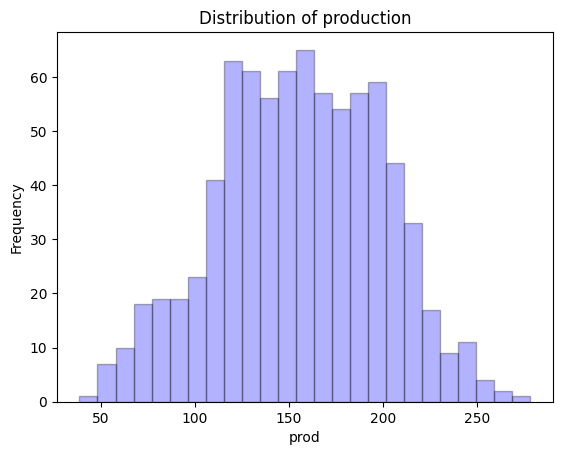

In [62]:
plt.hist(df['prod'], bins=25, color='blue', alpha=0.3, edgecolor='black')
plt.xlabel('prod')
plt.ylabel('Frequency')
plt.title('Distribution of production')
plt.show()

In [68]:
df[input_vars] = df[input_vars].astype(str)

In [80]:
# Label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df[input_vars] = df[input_vars].apply(le.fit_transform)

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df[['p1', 'p2', 'p3', 'p4', 'p5']].values
y = df['prod'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Nomralize the data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

from sklearn.metrics import mean_squared_error

print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

results

MSE: 397.20992526831355
RMSE: 19.93012607256446


,Actual,Predicted
0,99.679700,112.041113
1,69.047804,160.068636
2,133.122926,142.843585
3,103.336216,109.434329
4,114.531023,128.579976
...,...,...
154,121.442883,101.678039
155,173.029309,192.665849
156,150.325876,159.018116
157,184.261789,163.850926


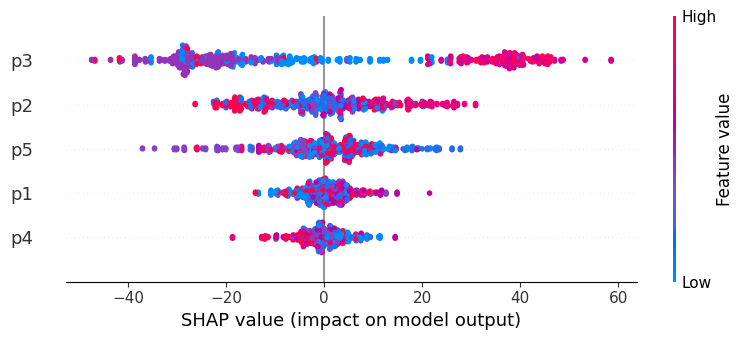

In [86]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=['p1', 'p2', 'p3', 'p4', 'p5'])
